# Evaluate BARPA-R for CAT turbulence indices.
Use a reanalysis such as BARRA-R or ERA5 for the "truth"

Evaluate:

    * pdf of values using quantiles and KS test
    * spatial distribution
    * time series


In [1]:
import xarray as xr
import glob
import intake
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import calendar
import os

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import logging
logging.getLogger("flox").setLevel(logging.WARNING)

In [2]:
from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
from matplotlib import colors, cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar
# ProgressBar().register()

import dask
from dask.distributed import Client
client = Client(threads_per_worker=2, n_workers=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36741,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:32815,Total threads: 2
Dashboard: /proxy/38181/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:42197,


In [3]:
mid_lat_slice = slice(-50,-25)
lon_slice = slice(90,195)
baseline_time_range = np.arange(1990,2009+1)
baseline_time_slice = slice("1990", "2009")

turbulence_index = "windspeed"
p95, p99, p999 = (62.835737276077246, 75.76162159729002, 88.1229062187195)

In [4]:
list_evaluation = ['evaluation_ERA5_r1i1p1f1', 
                   'evaluation_BARRA-R_r1i1p1f1']

list_historical = ['historical_ACCESS-CM2_r4i1p1f1', 
                   'historical_ACCESS-ESM1-5_r6i1p1f1',
                   'historical_CESM2_r11i1p1f1', 
                   'historical_CMCC-ESM2_r1i1p1f1',
                   'historical_EC-Earth3_r1i1p1f1',
                   'historical_MPI-ESM1-2-HR_r1i1p1f1',
                   'historical_NorESM2-MM_r1i1p1f1',
                  ]

In [5]:
frequency = "monthly"
filename = f"/scratch/v46/gt3409/turbulence_AUSCAT/windspeed-{frequency}_percentiles_midlatbox.nc"

if os.path.exists(filename):
    print(f"File '{filename}' already exists.")
    ds = xr.open_dataset(filename)
    ds.load()
else:
    run_filename_list = [f"/scratch/v46/gt3409/TMP_{turbulence_index}/TMP_{turbulence_index}-{frequency}-percentiles_AUS-15_{run}_BOM_BARPA-R_v1-r1_6hr.nc"
                                        for run in list_evaluation + list_historical]
    ds = xr.open_mfdataset(run_filename_list,
                                       concat_dim = "run",
                                       combine="nested",
                                       # chunks = {"run":1, 
                                       #           "time":-1, 
                                       #           # "lat":-1,
                                       #           "lon":111, 
                                       #           "quantile":-1},
                                       preprocess = lambda ds: ds.sel({"lat":mid_lat_slice, 
                                                                       "lon":lon_slice})\
                                                                 .astype("float32")\
                                                                 .mean(["lat", "lon"]),
                          )
    ds = ds.load()
    ds.to_netcdf(filename)

File '/scratch/v46/gt3409/turbulence_AUSCAT/windspeed-monthly_percentiles_midlatbox.nc' already exists.


# Kovmogolov-Smirnov two sample test for model evaluation

In [6]:
def plot_kstest(ds_eval, ds_hist, turbulence_index, time_selection, evaluation, run, pvalue, significance, ax=None, show_years=False):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(f"{run} in {time_selection}")        

    if show_years:
        # show each single year
        for year in np.arange(1990,2009):
            sns.lineplot(data = ds_eval.sel({"time": (ds_eval.time.dt.year==year)}).mean("time"),
                         x="windspeed",
                         y="quantile",
                         color="r",
                         alpha=0.1,
                         ax=ax)
        for year in np.arange(1990,2009):
            sns.lineplot(data = ds_hist.sel({"time": (ds_hist.time.dt.year==year)}).mean("time"),
                         x="windspeed",
                         y="quantile",
                         color="k",
                         alpha=0.1,
                         ax=ax)
            
    # empirical CDF for ks test        
    sns.ecdfplot(data = ds_eval.mean("time")["windspeed"], color="k", label=evaluation, ax=ax,)
    sns.ecdfplot(data = ds_hist.mean("time")["windspeed"], color="r", label=run, ax=ax,)
    
    # add pvalue to plot
    ax.text(x=0.98, y=0.02, s= f"pvalue = {pvalue:.3f}{significance}", transform = ax.transAxes, va="bottom", ha="right",)
    ax.set_xlabel(turbulence_index)
    ax.legend(loc="upper left", fontsize=10)
    # plt.close()
    return 


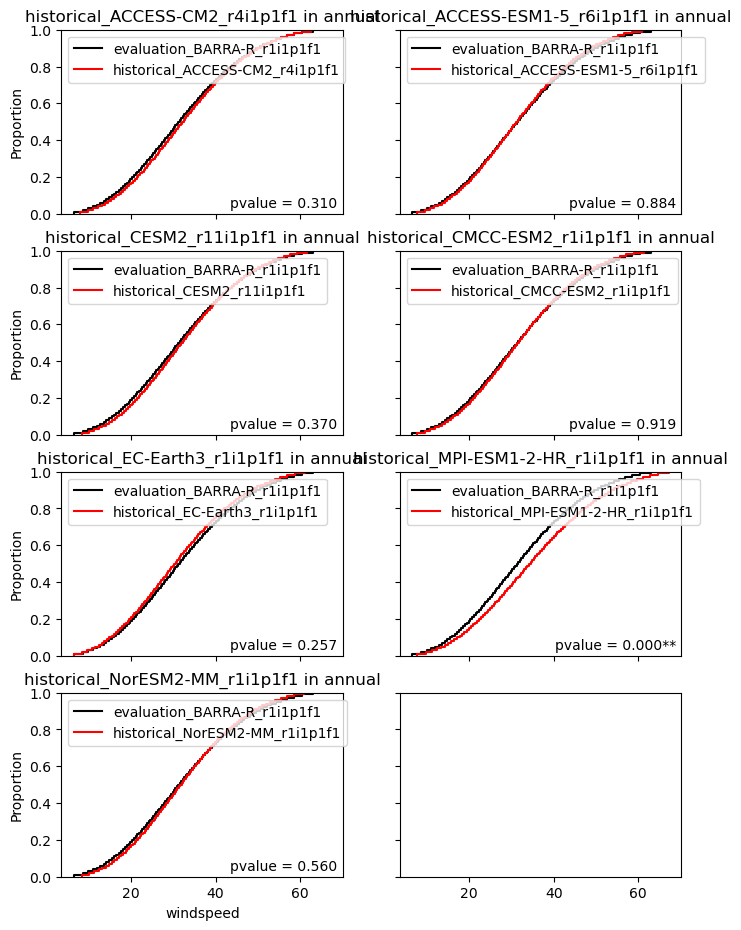

In [8]:
time_selection="annual"
nrows = 4
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols,
                         figsize=(8,11),
                         sharex=True, sharey=True)

# fig.suptitle(f"Model evaluation KS test for {time_selection}")
evaluation = list_evaluation[1]
for i, run in enumerate(list_historical):
    # annual
    ds_eval = ds.sel({"run":evaluation[:24]})
    ds_hist = ds.sel({"run":run[:24]})

    # calculate pvalue
    ks_statistic, pvalue = stats.ks_2samp(ds_eval.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                          ds_hist.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
    
    if pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = ""

    plot_kstest(ds_eval, ds_hist, turbulence_index, time_selection, evaluation, run, pvalue, significance, ax=axes[i//ncols, i%ncols])

fig.savefig(f"/home/563/gt3409/turbulence_AUSCAT/evaluation_kstest_plots_{time_selection}.png")


In [9]:
kstest_table = [["sample1", "sample2", "time_selection", "mon/seas/yr", "pvalue", "significance"]]

evaluation = list_evaluation[1]

for run in list_historical:
    # annual
    ds_eval = ds.sel({"run":evaluation[:24]})
    ds_hist = ds.sel({"run":run[:24]})

    # calculate pvalue
    ks_statistic, pvalue = stats.ks_2samp(ds_eval.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                          ds_hist.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
    
    if pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = ""

    # update ks test stats
    kstest_table.append([evaluation, run, "annual", "year", f"{pvalue:.3f}", significance])

    if False:
        plot_kstest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

    # seasonal
    for time_selection in ["DJF", "MAM", "JJA", "SON"]:
        ds_hist = ds.sel({"run":run[:24], "time": (ds.time.dt.season==time_selection)}).resample({"time":"QS-DEC"}).mean()
        ds_eval = ds.sel({"run":evaluation[:24], "time": (ds.time.dt.season==time_selection)}).resample({"time":"QS-DEC"}).mean()

        # calculate pvalue
        ks_statistic, pvalue = stats.ks_2samp(ds_eval.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                              ds_hist.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        # update ks test stats
        kstest_table.append([evaluation, run, time_selection, "season", f"{pvalue:.3f}", significance])

        if False:
            plot_kstest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

    # monthly
    for time_selection in np.arange(1,12+1):
        ds_hist = ds.sel({"run":run[:24], "time": (ds.time.dt.month==time_selection)})
        ds_eval = ds.sel({"run":evaluation[:24], "time": (ds.time.dt.month==time_selection)})

        # calculate pvalue
        ks_statistic, pvalue = stats.ks_2samp(ds_eval.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                              ds_hist.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
        # print(f"{run}: pvalue {pvalue:.3f}, ks_stat = {ks_statistic}")
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        kstest_table.append([evaluation, run, calendar.month_name[time_selection], "month", f"{pvalue:.3f}", significance])     

        if False:
            plot_kstest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

kstest_df = pd.DataFrame(columns = kstest_table[0], data = kstest_table[1:])
kstest_df.to_csv("/home/563/gt3409/turbulence_AUSCAT/evaluation_kstest_table.csv")
kstest_df

,sample1,sample2,time_selection,mon/seas/yr,pvalue,significance
0,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,annual,year,0.310,
1,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,DJF,season,0.999,
2,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,MAM,season,0.150,
3,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,JJA,season,0.082,
4,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,SON,season,0.212,
...,...,...,...,...,...,...
114,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,August,month,0.018,*
115,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,September,month,0.001,**
116,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,October,month,0.198,
117,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,November,month,0.948,


# Spatial evaluation

In [45]:
ds = xr.open_dataset("/scratch/v46/gt3409/turbulence_AUSCAT/windspeed-ann-freq-above-p99_mapped.nc")
ds = ds.sel({"time":baseline_time_slice, "lon":lon_slice, })
ds

<xarray.Dataset> Size: 569MB
Dimensions:    (run: 24, time: 20, lat: 436, lon: 680)
Coordinates:
  * lon        (lon) float64 5kB 90.04 90.2 90.35 90.51 ... 194.6 194.8 194.9
  * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
  * time       (time) datetime64[ns] 160B 1990-12-31 1991-12-31 ... 2009-12-31
    pressure   int64 8B ...
  * run        (run) <U27 3kB 'evaluation_BARRA-R_r1i1p1f1' ... 'ssp585_EC-Ea...
Data variables:
    windspeed  (run, time, lat, lon) float32 569MB ...
Attributes:
    regrid_method:  bilinear

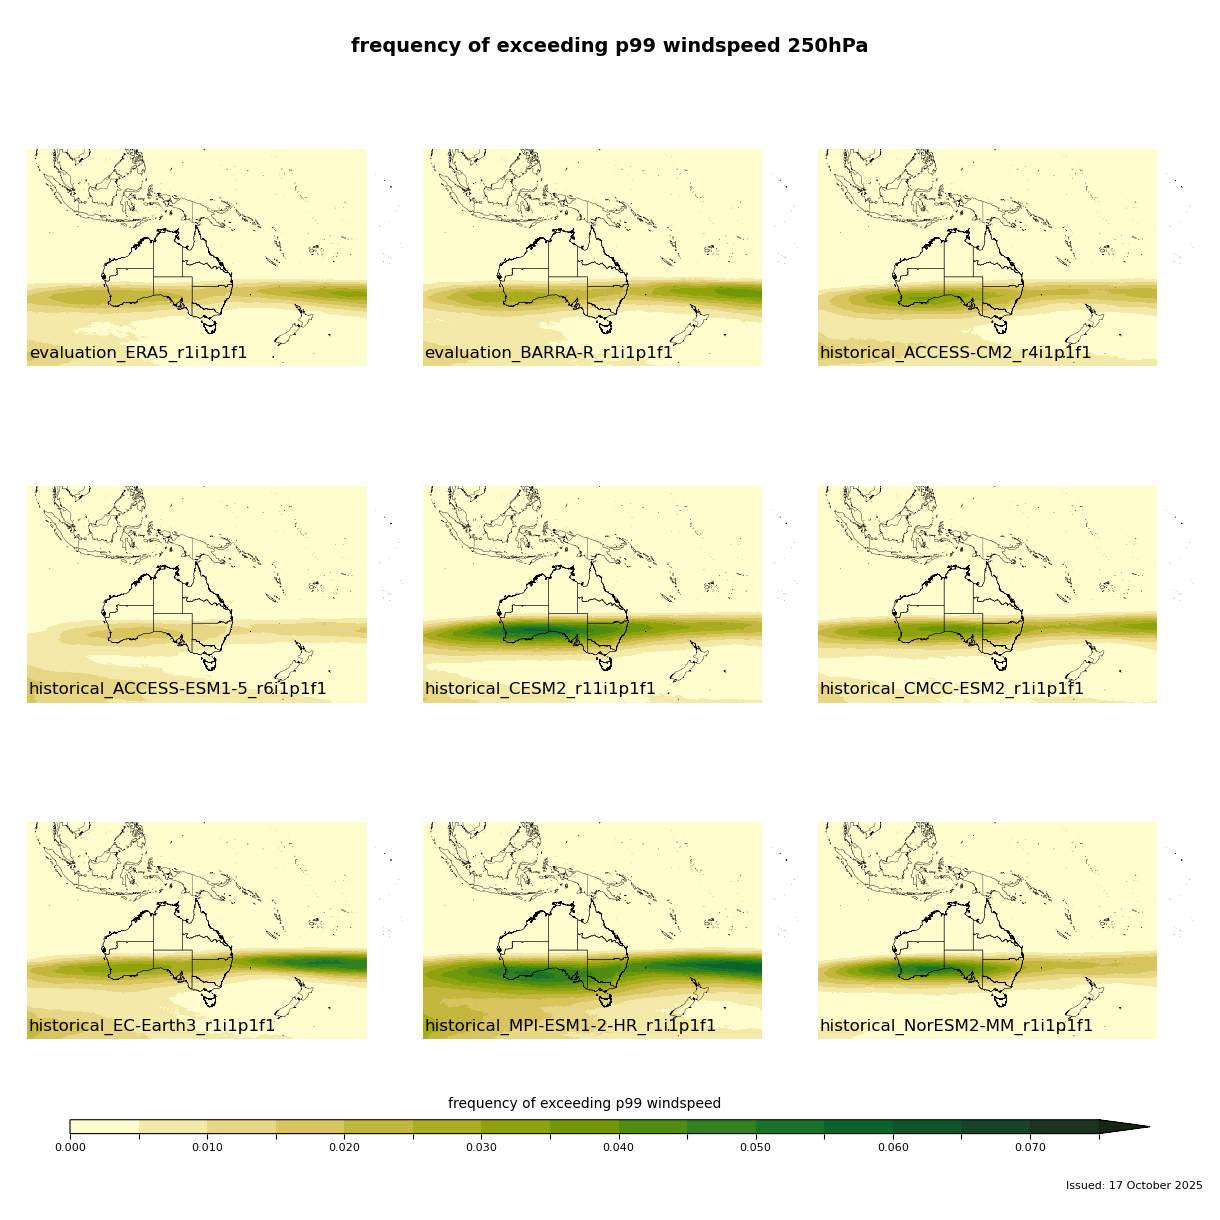

In [46]:
fig, axs = plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[ds.sel(run=run[:27])[f"{turbulence_index}"].mean("time")
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      figsize=(12,12),
                      title=f"frequency of exceeding p99 {turbulence_index} 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );

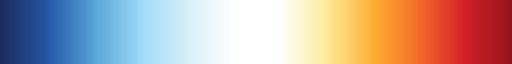

In [35]:
cmap_dict["anom"].set_bad("grey")
cmap_dict["anom"]

In [47]:
baseline = ds.sel(run='evaluation_BARRA-R_r1i1p1f1'[:27])[turbulence_index].mean("time")
baseline

<xarray.DataArray 'windspeed' (lat: 436, lon: 680)> Size: 1MB
array([[0.01105378, 0.0109852 , 0.01088264, ..., 0.00229359, 0.00225934,
        0.00232774],
       [0.011122  , 0.01125889, 0.0110536 , ..., 0.00219085, 0.002225  ,
        0.00212226],
       [0.01129323, 0.01139606, 0.01129332, ..., 0.00219085, 0.00219085,
        0.00212235],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
  * lon       (lon) float64 5kB 90.04 90.2 90.35 90.51 ... 194.6 194.8 194.9
  * lat       (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
    pressure  int64 8B ...
    run       <U27 108B 'evaluation_BARRA-R_r1i1p1f1'

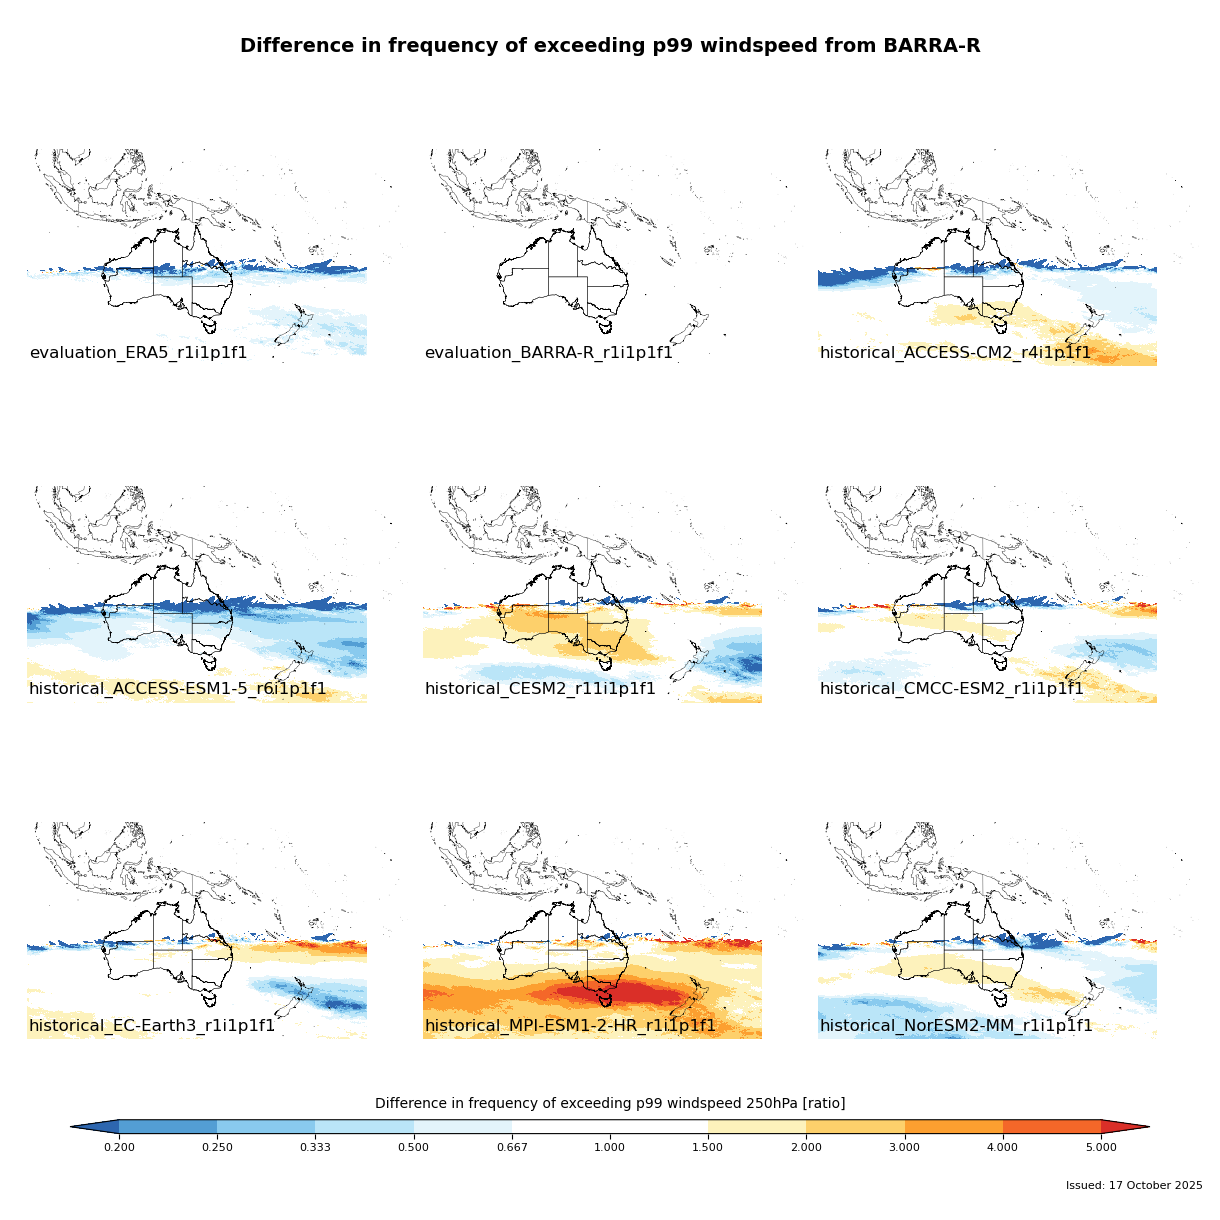

In [48]:
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[ds.sel(run=run[:27])[turbulence_index].mean("time")/baseline 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=[1/5, 1/4, 1/3, 1/2, 2/3, 1, 3/2, 2, 3, 4, 5],
                      vcentre=1,
                      tick_interval=1,
                      cbar_extend="both",
                      title=f"Difference in frequency of exceeding p99 {turbulence_index} from BARRA-R",
                      figsize=(12,12),
                      cbar_label=f"Difference in frequency of exceeding p99 {turbulence_index} 250hPa [ratio]",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );

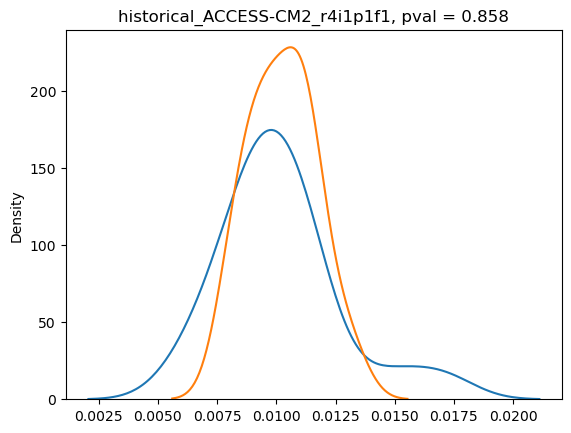

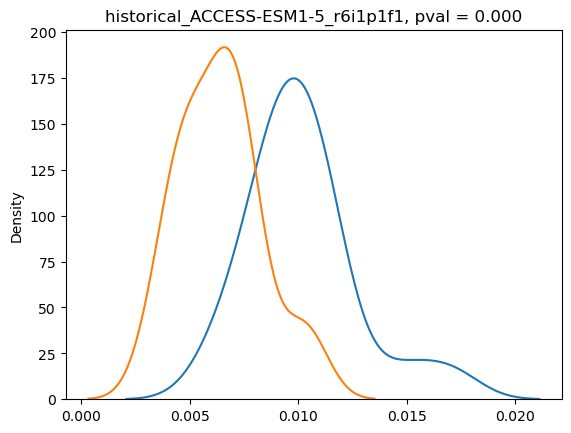

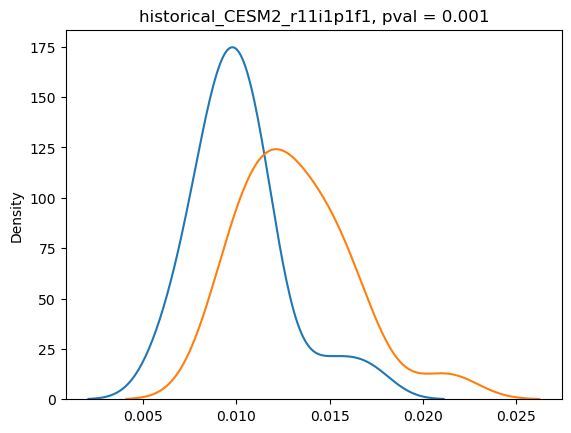

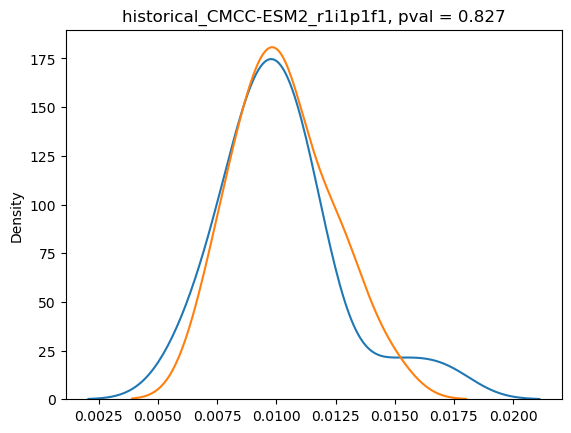

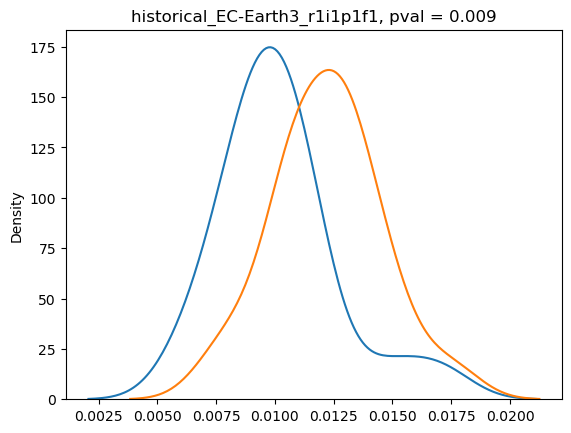

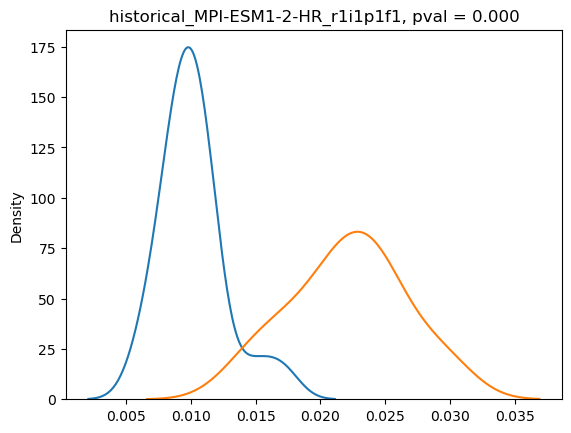

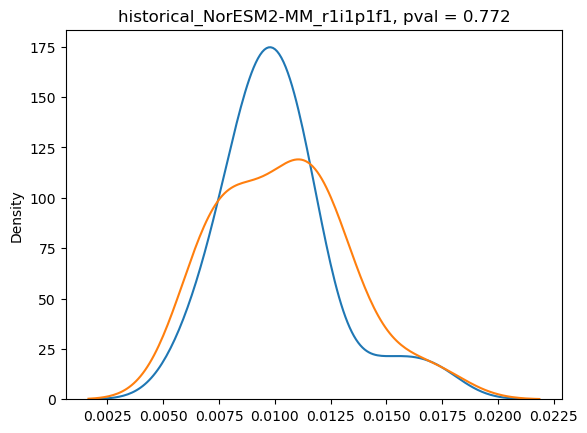

In [66]:
# do this point-wise??
ds_mid_lat_means = ds.sel({"lat":mid_lat_slice, "lon":lon_slice}).mean(["lat", "lon"])[turbulence_index]

ds_eval = ds_mid_lat_means.isel(run=0)
for run in list_historical:
    plt.figure()
    ds_hist = ds_mid_lat_means.sel(run=run[:27])
    sns.kdeplot(ds_eval)
    sns.kdeplot(ds_hist)
    stat, pval = stats.ttest_ind(ds_eval, ds_hist)
    plt.title(f"{run}, pval = {pval:.3f}")

In [50]:
ds.isel(run=3)[turbulence_index]

<xarray.DataArray 'windspeed' (time: 20, lat: 436, lon: 680)> Size: 24MB
[5929600 values with dtype=float32]
Coordinates:
  * lon       (lon) float64 5kB 90.04 90.2 90.35 90.51 ... 194.6 194.8 194.9
  * lat       (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
  * time      (time) datetime64[ns] 160B 1990-12-31 1991-12-31 ... 2009-12-31
    pressure  int64 8B ...
    run       <U27 108B 'historical_ACCESS-ESM1-5_r6'

In [ ]:
stats.ttest_ind(sample1, sample2)
print(f"Independent Two-Sample T-test: t-statistic={t_statistic:.3f}, p-value={p_value:.3f}")

In [6]:
%%time
turbulence_index = "windspeed"
threshold = p99

delayed_results =[]
for run in list_evaluation + list_historical:
    experiment_id, source_id, member_id = run.split("_")
    print(run)

    def _preprocess(ds, threshold=p99):
        return (ds.chunk({"time":-1,})>threshold).mean(dim=["time"])

    time_range = np.arange(1990, 2009+1)
    filelist = [ f"/scratch/v46/gt3409/TMP_{turbulence_index}/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
                for year in time_range]
    
    ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested", concat_dim="time").assign_coords({"run":run, "time":time_range})
    delayed_results.append(ds)

results = dask.compute(delayed_results)
results

evaluation_ERA5_r1i1p1f1
evaluation_BARRA-R_r1i1p1f1
historical_ACCESS-CM2_r4i1p1f1
historical_ACCESS-ESM1-5_r6i1p1f1
historical_CESM2_r11i1p1f1
historical_CMCC-ESM2_r1i1p1f1
historical_EC-Earth3_r1i1p1f1
historical_MPI-ESM1-2-HR_r1i1p1f1
historical_NorESM2-MM_r1i1p1f1


2025-09-25 14:40:59,401 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:36883 -> tcp://127.0.0.1:34737
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/comm/

CPU times: user 8min 3s, sys: 3min 12s, total: 11min 16s
Wall time: 55min 58s


([<xarray.Dataset> Size: 54MB
  Dimensions:    (time: 20, lat: 436, lon: 777)
  Coordinates:
    * lon        (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
    * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
      pressure   int64 8B 250
      run        <U24 96B 'evaluation_ERA5_r1i1p1f1'
    * time       (time) int64 160B 1990 1991 1992 1993 ... 2006 2007 2008 2009
  Data variables:
      windspeed  (time, lat, lon) float64 54MB 0.006849 0.007534 ... 0.0 0.0,
  <xarray.Dataset> Size: 54MB
  Dimensions:    (time: 20, lat: 436, lon: 777)
  Coordinates:
      pressure   int64 8B 250
    * lon        (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
    * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
      run        <U27 108B 'evaluation_BARRA-R_r1i1p1f1'
    * time       (time) int64 160B 1990 1991 1992 1993 ... 2006 2007 2008 2009
  Data variables:
      windspeed  (time, lat, lon) float64 54MB 0.0 0.0 0

In [7]:
hist_eval = xr.concat(results[0], dim=["run"])
hist_eval

ValueError: conflicting sizes for dimension 'concat_dim': length 1 on 'concat_dim' and length 9 on {'lon': 'lon', 'lat': 'lat', 'concat_dim': 'run', 'time': 'time'}

In [ ]:
xr.open_dataset("/scratch/v46/gt3409/TEMP_era5_1979-2022.nc")

In [ ]:
hist_eval

In [ ]:
hist_eval.to_netcdf("/scratch/v46/gt3409/historical_evaluation_1990-2009.nc")

In [170]:
hist_eval = xr.open_dataset("/scratch/v46/gt3409/historical_evaluation_1990-2009.nc")#.sel(lon=slice(88.0355,196.89))
hist_eval

<xarray.Dataset> Size: 488MB
Dimensions:    (run: 9, time: 20, lat: 436, lon: 777)
Coordinates:
  * lon        (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
  * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
    pressure   int64 8B ...
  * run        (run) <U33 1kB 'evaluation_ERA5_r1i1p1f1' ... 'historical_NorE...
  * time       (time) int64 160B 1990 1991 1992 1993 ... 2006 2007 2008 2009
Data variables:
    windspeed  (run, time, lat, lon) float64 488MB ...

In [ ]:
# hist_eval = xr.open_dataset("/scratch/v46/gt3409/historical_evaluation.nc")

In [ ]:
# hist_eval

In [ ]:
era5 = hist_eval.sel(run='evaluation_ERA5_r1i1p1f1')["windspeed"].mean("time")
barra = hist_eval.sel(run='evaluation_BARRA-R_r1i1p1f1')["windspeed"].mean("time")

In [ ]:
fig, axs = plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[hist_eval.sel(run=run)["windspeed"].mean("time") 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label="frequency of exceeding p99 windspeed",
                      figsize=(12,12),
                      title="frequency of exceeding p99 windspeed 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );


In [ ]:
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[(hist_eval.sel(run=run)["windspeed"].mean("time") - barra) 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(-0.05, 0.051, 0.005),
                      tick_interval=2,
                      cbar_extend="both",
                      title="Difference in frequency of exceeding p99 windspeed from BARRA-R",
                      figsize=(12,12),
                      cbar_label="frequency of exceeding p99 windspeed 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );

In [ ]:
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[(hist_eval.sel(run=run)["windspeed"].mean("time") - era5) 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(-0.05, 0.051, 0.005),
                      tick_interval=2,
                      cbar_extend="both",
                      title="Difference in frequency of exceeding p99 windspeed from ERA5",
                      figsize=(12,12),
                      cbar_label="frequency of exceeding p99 windspeed 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );
                      

In [ ]:
%%time
for run in list_evaluation+ list_historical:
    plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree(130))
    hist_eval.sel(run=run)["windspeed"].mean("time").plot(vmax=0.08, transform=ccrs.PlateCarree(), ax=ax)
    plt.title(run)
    ax.yaxis.set_visible(True)
    ax.grid()
    ax.coastlines()


In [ ]:
for run in list_evaluation+list_historical:
    plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree(130))
    (hist_eval.sel(run=run)["windspeed"].mean("time") - barra).plot(cmap="RdBu_r", vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree(), ax=ax)
    plt.title(run)
    ax.yaxis.set_visible(True)
    ax.grid()
    ax.coastlines()

In [ ]:
for run in list_evaluation+list_historical:
    plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree(130))
    (hist_eval.sel(run=run)["windspeed"].mean("time") - era5).plot(cmap="RdBu_r", vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree(), ax=ax)
    plt.title(run)
    ax.yaxis.set_visible(True)
    ax.grid()
    ax.coastlines()

In [ ]:
%%time
turbulence_index = "windspeed"

quantiles_models ={}
for run in list_evaluation + list_historical:
    experiment_id, source_id, member_id = run.split("_")
    print(run)

    for year in np.arange(1990,2009+1):
        # opening
        file = f"/scratch/v46/gt3409/TMP_windspeed/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc"
        ds_model = xr.open_dataset(file,).assign_coords({"run":run, "year":year})
    
        quantiles_models[f"{run}"] = dask.delayed(ds_model.quantile)(np.arange(0, 1, 0.01),)

results = dask.compute(quantiles_models,)
results

In [ ]:
quantiles_models = xr.concat([results[0][run] for run in list_evaluation + list_historical], 
                             dim="run").assign_coords({"run": list_evaluation + list_historical})
quantiles_models

In [ ]:
%%time
turbulence_index = "windspeed"
fig, axs = plt.subplots(5,2, figsize=(8,12), sharex=True, sharey=True)
i=0
for run in list_evaluation + list_historical:
    print(run)
    # if p-value is less than 0.05 then reject that model
    var = "windspeed"

    plot_model_obs_kde(quantiles_models[var].sel({"run":run}),
                       quantiles_models[var].sel({"run":list_evaluation[1]}),
                       title=f"{run}",
                       xlabel = f"ANN {var}",
                       ax = axs[i//2, i%2])
    plt.xlim(0,100)
    i+=1

In [ ]:
%%time
turbulence_index = "windspeed"
fig, axs = plt.subplots(5,2, figsize=(8,12), sharex=True, sharey=True)
i=0
for run in list_evaluation + list_historical:
    print(run)
    # if p-value is less than 0.05 then reject that model
    var = "windspeed"

    plot_model_obs_kde(quantiles_models[var].sel({"run":run}),
                       quantiles_models[var].sel({"run":list_evaluation[0]}),
                       title=f"{run}",
                       xlabel = f"ANN {var}",
                       ax = axs[i//2, i%2])
    plt.xlim(0,100)
    i+=1

In [ ]:
%%time
turbulence_index = "windspeed"
for run in list_evaluation + list_historical:
    experiment_id, source_id, member_id = run.split("_")
    print(run)

    plt.figure()
    quantiles_models[var].sel({"run":list_evaluation[0]}).plot(color="k",linestyle="--")
    quantiles_models[var].sel({"run":run}).plot(color="r")
    plt.show
    